In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Using TensorFlow backend.


In [0]:
dataframe = pd.read_csv('/content/drive/My Drive/Mediciones en csv/HTLOS CSV/potencia 2000-01-03 21_3A11_3A34 Antenna Horn Time 300[s] SwitchingBy 0 Horn 0 Omni 0 ING-AU_033.csv', header= None)

In [0]:
dataset = dataframe.values

In [4]:
#dataset
POT = dataset[0:len(dataset),1]
print(POT.shape)

(210108,)


Text(0.5, 1.0, 'Datos reales')

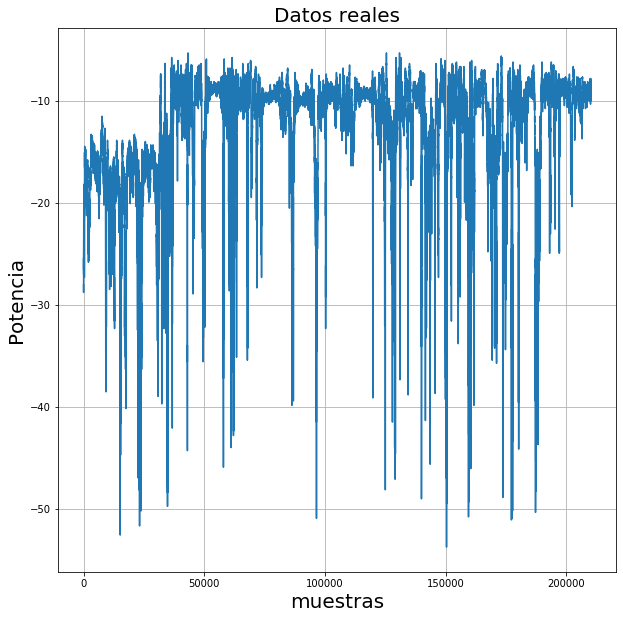

In [79]:
plt.figure(figsize=[10,10])
plt.grid()
plt.plot(POT)
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.title("Datos reales", fontsize = 20)

In [6]:
#llevo la funcion a un arreglo de [lARGO DEL ARREGLO ,1] PARA ESCALAR LOS DATOS
POT2=POT.reshape(len(POT),1)
print(POT2.shape)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
POT2 = scaler.fit_transform(POT2)

(210108, 1)


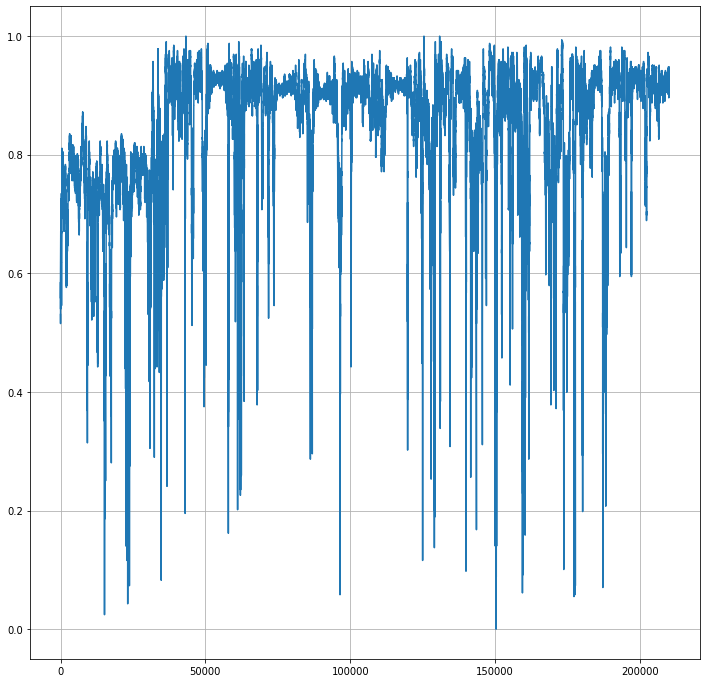

In [8]:
plt.figure(figsize=[12,12])
plt.grid()
plt.plot(POT2)

In [9]:
# divido la funcion y1 en arreglos para entrenar y probar la red
train_size = int(len(POT2) * 0.8)
test_size = len(POT2) - train_size
train, test = POT2[0:train_size,:], POT2[train_size:len(POT2),:]
print(len(train), len(test))
print(train.shape)
print(test.shape)

168086 42022
(168086, 1)
(42022, 1)


In [0]:
# convertir un arreglo de valores en una matrix
def create_dataset(POT2, look_back=1):
    dataX, dataY = [], []
    for i in range(len(POT2)-look_back-1):
        a = POT2[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(POT2[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# reshape dentro X=t and Y=t+1
look_back = 5
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)
print(trainX[0])
print(trainY[0])
print(trainX[1])
print(trainY[1])
print(trainX[2])
print(trainY[3])

(168080, 5)
(42016, 5)
(168080,)
(42016,)
[0.53056588 0.5243701  0.53655514 0.53056588 0.53965304]
0.5456422965716645
[0.5243701  0.53655514 0.53056588 0.53965304 0.5456423 ]
0.530565881866997
[0.53655514 0.53056588 0.53965304 0.5456423  0.53056588]
0.5243700950020652


In [12]:
# reshape a la entrada [samples, time steps, features] que es necesario para la red lstm
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(testX.shape)

(168080, 1, 5)
(42016, 1, 5)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               42400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 42,501
Trainable params: 42,501
Non-trainable params: 0
_________________________________________________________________


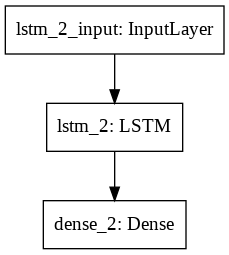

In [15]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(100,input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse', 'mae', 'mape'])
model.summary()
keras.utils.plot_model(model, 'my_first_model.png')

In [16]:
History = model.fit(trainX, trainY, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
168080/168080 [==============================] - 16s 95us/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0157 - mean_absolute_percentage_error: 2259.0885
Epoch 2/50
168080/168080 [==============================] - 15s 89us/step - loss: 1.8389e-04 - mean_squared_error: 1.8389e-04 - mean_absolute_error: 0.0063 - mean_absolute_percentage_error: 1790.2371
Epoch 3/50
168080/168080 [==============================] - 15s 88us/step - loss: 1.2647e-04 - mean_squared_error: 1.2647e-04 - mean_absolute_error: 0.0056 - mean_absolute_percentage_error: 1269.7726
Epoch 4/50
168080/168080 [==============================] - 16s 93us/step - loss: 1.1463e-04 - mean_squared_error: 1.1463e-04 - mean_absolute_error: 0.0054 - mean_absolute_percentage_error: 1179.1086
Epoch 5/50
168080/168080 [==============================] - 15s 90us/step - loss: 1.0729e-04 - mean_squared_error: 1.0729e-04 - mean_absolute_error: 0.0052 - mean_absolute_percentage_error: 1177.8478
Epoch 6/

In [17]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
print('Train Mean Absolute Error:', mean_absolute_error(trainY[0], trainPredict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(testY[0], testPredict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(testY[0], testPredict[:,0])))

Train Score: 0.46 RMSE
Test Score: 0.51 RMSE
Train Mean Absolute Error: 0.23113336905532073
Train Root Mean Squared Error: 0.4563095892373561
Test Mean Absolute Error: 0.25293743363338295
Test Root Mean Squared Error: 0.5059568573463112


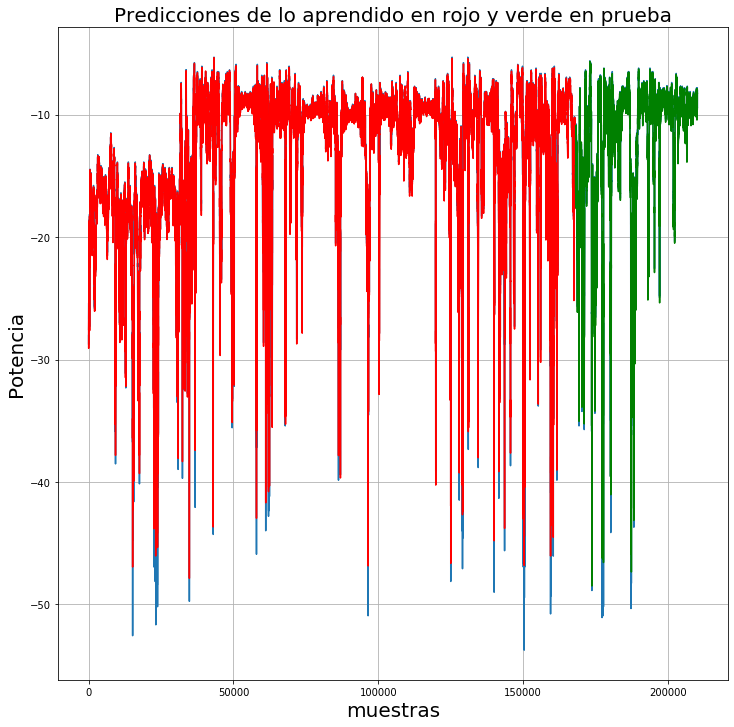

In [76]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(POT2)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(POT2)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(POT2)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=[12,12])
plt.plot((POT))
plt.plot(trainPredictPlot, color="red", )
plt.xlabel("muestras",fontsize = 20)
plt.ylabel("Potencia",fontsize = 20)
plt.plot(testPredictPlot, color="green")
plt.title("Predicciones de lo aprendido en rojo y verde en prueba", fontsize = 20)
plt.grid()
plt.show()

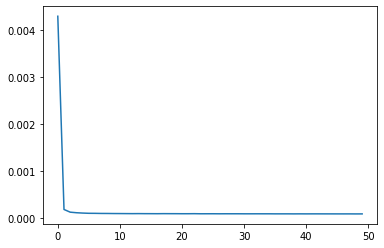

In [20]:
# plot metrics
plt.plot(History.history['mean_squared_error'])

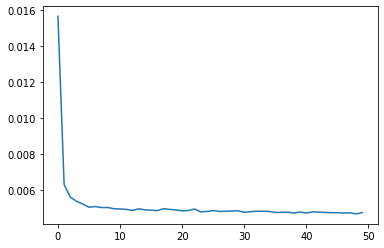

In [21]:
plt.plot(History.history['mean_absolute_error'])

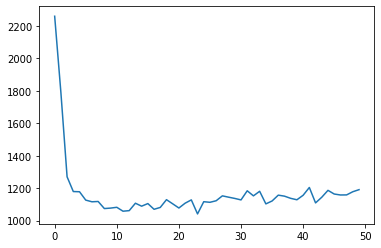

In [22]:
plt.plot(History.history['mean_absolute_percentage_error'])

In [25]:
# 5. make predictions
predictions = model.predict(testX, verbose=1, batch_size=64)
print(predictions[:, 0])

42016/42016 [==============================] - 1s 28us/step
[0.8170374  0.81802744 0.80166906 ... 0.93735707 0.9401302  0.93922067]


In [26]:
DATOS_PRED=testPredict[:,0]
DATOS_PRED

array([-14.169048, -14.121111, -14.913184, ...,  -8.34317 ,  -8.208897,
        -8.252935], dtype=float32)

In [27]:
print(len(predictions))
print(len(DATOS_PRED))

42016
42016


[0.82321355 0.82011565 0.81391987 ... 0.94196613 0.94506402 0.94196613]
42022


In [0]:
test_real = scaler.inverse_transform(test)

In [33]:
len(test_real[:,0])

42022

In [34]:
len(test_real[4:42020,0])

42016

In [42]:
DATOS_REAL= test_real[4:42020,0]

print(DATOS_REAL)
print(len(DATOS_REAL))

[-14.17 -14.02 -14.61 ...  -8.27  -8.12  -8.12]
42016


In [43]:
DR_df=pd.DataFrame(DATOS_REAL, columns=['Datos reales'])
DR_df.head(10)

,Datos reales
0,-14.17
1,-14.02
2,-14.61
3,-14.91
4,-14.91
5,-14.76
6,-14.76
7,-15.06
8,-15.20
9,-15.35


In [45]:
# haciendo las predicciones
predicciones_df = pd.DataFrame(DATOS_PRED, columns=['Predicciones'])
predicciones_df.head(10) # predicciones de las primeras 5 lineas

,Predicciones
0,-14.169048
1,-14.121111
2,-14.913184
3,-15.027986
4,-14.985012
5,-14.812524
6,-14.888552
7,-15.264627
8,-15.317001
9,-15.492888


In [0]:
acc = abs(DATOS_PRED-DATOS_REAL)

In [62]:
error_df = pd.DataFrame(acc, columns=['Error'])
error_df.head(10)

,Error
0,0.000952
1,0.101111
2,0.303184
3,0.117986
4,0.075012
5,0.052524
6,0.128552
7,0.204627
8,0.117001
9,0.142888


In [0]:
mostrar = DATOS_PRED, DATOS_REAL, acc

In [0]:
mostrar = np.array(mostrar)

In [0]:
mostrar_good =np.transpose(mostrar)

In [75]:
Tabla_df = pd.DataFrame(mostrar_good, columns=['Datos predichos','Datos reales','Error'])
Tabla_df

,Datos predichos,Datos reales,Error
0,-14.169048,-14.17,0.000952
1,-14.121111,-14.02,0.101111
2,-14.913184,-14.61,0.303184
3,-15.027986,-14.91,0.117986
4,-14.985012,-14.91,0.075012
...,...,...,...
42011,-8.548018,-8.41,0.138018
42012,-8.521497,-8.41,0.111497
42013,-8.343170,-8.27,0.073170
42014,-8.208897,-8.12,0.088897


In [0]:
#model.add(LSTM(128, activation = 'relu',return_sequences=True,input_shape=(1, look_back)))
#model.add(LSTM(64,return_sequences=True))
#model.add(LSTM(64))
#model.add(Dense(64))
#model.add(Dense(32))
#model.add(Dense(1))
#model.add(LSTM(100, activation = 'relu',input_shape=(1, look_back)))
#model.add(Dense(100))
#model.add(Dense(1))